In [39]:

import pandas as pd
import torch
# @title Load Data


path='DS-ALS-REDSEA-CLEANED.csv'  # @param {type: "string"}
df = pd.read_csv(path)
# @title PreProcessing Raw Data

Timestamp=df['Timestamp']
Speed=df['Speed']
Course=df['Course']
Latitude=df['Latitude']
Longitude=df['Longitude']
Vessel=df['Vessel']
new_df=pd.DataFrame({'Timestamp':Timestamp,'Speed':Speed,'Course':Course,'Latitude':Latitude,'Longitude':Longitude,'Vessel':Vessel})

#  REMOVE  VALUE masked     IN TABLE
df_cleaned = new_df.dropna()

df_cleaned = df_cleaned.replace('masked', pd.NA)
df_cleaned = df_cleaned.dropna()
df_cleaned['Latitude'] = df_cleaned['Latitude'].astype(float)
df_cleaned['Longitude'] = df_cleaned['Longitude'].astype(float)
df_cleaned['Speed'] = df_cleaned['Speed'].astype(float)
df_cleaned['Course']=df_cleaned['Course'].astype(float)

# Filter data based on latitude and longitude ranges
df_cleaned = df_cleaned[(df_cleaned['Longitude'] >= 32) & (df_cleaned['Longitude'] <= 44)]
df_cleaned = df_cleaned[(df_cleaned['Latitude'] >= 12) & (df_cleaned['Latitude'] <= 33)]

df_cleaned.sort_values(by=['Timestamp'], inplace=True)
df_cleaned.reset_index(drop=True, inplace=True)


vs=df_cleaned['Vessel'].unique()

# Group data by vessel and count the number of points in each trajectory
vessel_counts = df_cleaned.groupby('Vessel').size()

# Filter out vessels with more than 100 points
vessels_to_keep = vessel_counts[vessel_counts <= 150].index

# Filter the DataFrame to keep only the trajectories with 100 or fewer points
df_filtered = df_cleaned#[df_cleaned['Vessel'].isin(vessels_to_keep)]

# Find min/max latitude and longitude for the filtered data
min_lat = df_filtered['Latitude'].min()
max_lat = df_filtered['Latitude'].max()
min_lon = df_filtered['Longitude'].min()
max_lon = df_filtered['Longitude'].max()
min_time=df_filtered['Timestamp'].min()
max_time=df_filtered['Timestamp'].max()
max_speed=df_filtered['Speed'].max()
min_speed=df_filtered['Speed'].min()
min_course=df_filtered['Course'].min()

max_course=df_filtered['Course'].max()


print(f"Min Latitude: {min_lat}")
print(f"Max Latitude: {max_lat}")
print(f"Min Longitude: {min_lon}")
print(f"Max Longitude: {max_lon}")
print(f"Min Timestamp: {min_time}")
print(f"Max Timestamp: {max_time}")
print(f"Min Speed: {min_speed}")
print(f"Max Speed: {max_speed}")
print(f"Min Course: {min_course}")
print(f"Max Course: {max_course}")
df_cleaned=df_filtered


Min Latitude: 12.29372
Max Latitude: 31.64791
Min Longitude: 32.10303
Max Longitude: 43.99368
Min Timestamp: 2024-07-01 00:17:08
Max Timestamp: 2024-11-22 23:59 UTC
Min Speed: 0.0
Max Speed: 44.55
Min Course: 0.0
Max Course: 359.0


In [40]:
from datetime import datetime
import pytz

def convert_to_numeric(timestamp_str):
    try:
        # Attempt to parse with seconds
        timestamp = datetime.strptime(timestamp_str.replace(' UTC', ''), "%Y-%m-%d %H:%M:%S").replace(tzinfo=pytz.utc)
    except ValueError:
        # If parsing with seconds fails, try without seconds
        timestamp = datetime.strptime(timestamp_str.replace(' UTC', ''), "%Y-%m-%d %H:%M").replace(tzinfo=pytz.utc)
    return int(timestamp.timestamp())

df_cleaned['Timestamp'] = df_cleaned['Timestamp'].apply(lambda x: convert_to_numeric(x))

In [47]:
# @title Four-Hot

LAT_BINS = 100  # @param {type: "number"}
LON_BINS = 100  # @param {type: "number"}
SOG_BINS = 50  # @param {type: "number"}
COG_BINS = 10  # @param {type: "number"}

data=[]
labels=[]
features=['Latitude','Longitude','Speed','Course','Timestamp']
for v in vs:
  v1=df_cleaned[df_cleaned['Vessel']==v]
  fs=v1[features].values

  fs=torch.tensor(fs)

  fs[:,0]=fs[:,0]/LAT_BINS
  fs[:,1]=fs[:,1]/LON_BINS
  fs[:,2]=fs[:,2]/SOG_BINS
  fs[:,3]=fs[:,3]/360
  fs[:,4]=fs[:,4]
  if len(fs)>2:
      data.append({'mmsi':int(str(uuid.uuid4().int)[:8]),"traj":fs})

Double_DATA=1   # @param {type: "number"}
data=data*Double_DATA


In [32]:
!pip install fastdtw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp311-cp311-linux_x86_64.whl size=542085 sha256=d9f9f0b34b11452a06e5f915e32060f0d9afb71090073d2c83b2adedb477c704
  Stored in directory: /root/.cache/pip/wheels/5c/8a/f6/fd3df9a9714677410a5ccbf3ca519e66db4a54a1c46ea95332
Successfully built fastdtw


In [68]:
import numpy as np
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

def compute_dtw_distance(traj1, traj2):
    distance, _ = fastdtw(traj1, traj2, dist=euclidean)
    return distance

def find_feature_trajectory(potential_trajectories):
    min_distance = float('inf')
    feature_trajectory = None

    for traj in potential_trajectories:
        for candidate in potential_trajectories:
            if traj != candidate:
                distance = compute_dtw_distance(traj, candidate)
                if distance < min_distance:
                    min_distance = distance
                    feature_trajectory = traj

    return feature_trajectory

def calculate_translation_distance(feature_point, missing_point):
    delta_longitude = feature_point[0] - missing_point[0]
    delta_latitude = feature_point[1] - missing_point[1]
    return delta_longitude, delta_latitude

def reconstruct_missing_data(feature_trajectory, missing_trajectory):
    reconstructed_trajectory = []

    for i in range(len(missing_trajectory)):
        missing_point = missing_trajectory[i]
        closest_feature_point = feature_trajectory[i % len(feature_trajectory)]
        delta_longitude, delta_latitude = calculate_translation_distance(closest_feature_point, missing_point)
        new_point = (missing_point[0] + delta_longitude, missing_point[1] + delta_latitude)
        reconstructed_trajectory.append(new_point)

    return reconstructed_trajectory

traj1 = [(1, 2), (2, 3), (3, 4), (4, 5)]
traj2 = [(1.1, 2.1), (2.2, 3.2), (3.3, 4.3), (4.4, 5.4)]
traj3 = [(1.2, 2.2), (2.3, 3.3), (3.4, 4.4), (4.5, 5.5)]
potential_trajectories = [traj1, traj2, traj3]

missing_trajectory = [(2, 0), (3, 4), (4, 5)]

feature_trajectory = find_feature_trajectory(potential_trajectories)
print("Feature Trajectory:", feature_trajectory)

reconstructed_trajectory = reconstruct_missing_data(feature_trajectory, missing_trajectory)
print("Reconstructed Trajectory:", reconstructed_trajectory)


Feature Trajectory: [(1.1, 2.1), (2.2, 3.2), (3.3, 4.3), (4.4, 5.4)]
Reconstructed Trajectory: [(1.1, 2.1), (2.2, 3.2), (3.3, 4.3)]


In [34]:
!pip install dtw-python


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.7/801.7 kB 12.7 MB/s eta 0:00:00


<ipython-input-42-594eff177f9b>:21: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['COG'][i] = data['COG'][i-1] + ROT * (data['time'][i] - data['time'][i-1])
<ipython-input-42-594eff177f9b>:21: FutureWarning: ChainedAssignmentError: beha

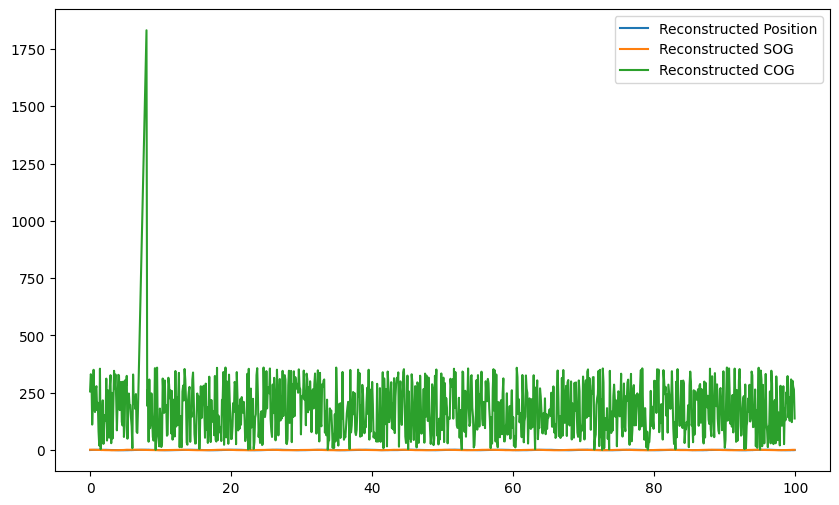

In [42]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from dtw import *
import math

def reconstruct_noise(data, noise_type='position', degree=2):
    data['value'] = data[noise_type]
    clean_data = data[~data['value'].isna()]
    f = interp1d(clean_data['time'], clean_data['value'], kind=degree, fill_value="extrapolate")
    data['value'] = f(data['time'])
    data[noise_type] = data['value']
    data = data.drop(columns=['value'])
    return data

def reconstruct_COG(data):
    for i in range(1, len(data)):
        if math.isnan(data['COG'][i]):
            ROT = (data['COG'][i-1] - data['COG'][i-2]) / (data['time'][i] - data['time'][i-1])
            data['COG'][i] = data['COG'][i-1] + ROT * (data['time'][i] - data['time'][i-1])
    return data

def reconstruct_missing_data(data, missing_indices, historical_trajectories):
    min_distance = float('inf')
    best_match_trajectory = None
    for trajectory in historical_trajectories:
        dist, _ = fastdtw(data[missing_indices], trajectory, dist=euclidean)
        if dist < min_distance:
            min_distance = dist
            best_match_trajectory = trajectory
    reconstructed_data = data.copy()
    reconstructed_data[missing_indices] = best_match_trajectory
    return reconstructed_data

if __name__ == "__main__":
    time = np.arange(0, 100, 0.1)
    position = np.sin(time) + np.random.normal(0, 0.1, len(time))
    SOG = np.cos(time) + np.random.normal(0, 0.1, len(time))
    COG = np.random.uniform(0, 360, len(time))
    data = pd.DataFrame({'time': time, 'position': position, 'SOG': SOG, 'COG': COG})
    data.loc[20:30, 'position'] = np.nan
    data.loc[50:60, 'SOG'] = np.nan
    data.loc[70:80, 'COG'] = np.nan
    data = reconstruct_noise(data, noise_type='position', degree=2)
    data = reconstruct_noise(data, noise_type='SOG', degree=2)
    data = reconstruct_COG(data)
    historical_trajectories = [np.sin(np.arange(0, 100, 0.1) + np.random.normal(0, 0.1, 1000)) for _ in range(5)]
    missing_indices = np.isnan(data['position'])
    data['position'] = reconstruct_missing_data(data['position'], missing_indices, historical_trajectories)
    plt.figure(figsize=(10, 6))
    plt.plot(data['time'], data['position'], label='Reconstructed Position')
    plt.plot(data['time'], data['SOG'], label='Reconstructed SOG')
    plt.plot(data['time'], data['COG'], label='Reconstructed COG')
    plt.legend()
    plt.show()


In [43]:
import numpy as np
import torch
import torch.nn.functional as F

class FourHotEncoder:
    def __init__(self, lat_range, lon_range, sog_max, n_bins):
        self.lat_bins = np.linspace(lat_range[0], lat_range[1], n_bins[0])
        self.lon_bins = np.linspace(lon_range[0], lon_range[1], n_bins[1])
        self.sog_bins = np.linspace(0, sog_max, n_bins[2])
        self.cog_bins = np.linspace(0, 360, n_bins[3])

    def gaussian_encoding(self, value, bins):
        diff = np.abs(value - bins)
        encoding = np.exp(-diff**2 / (2 * (np.std(bins) ** 2)))
        return encoding / encoding.sum()  # Normalize

    def encode(self, x):
        lat_enc = self.gaussian_encoding(x[0], self.lat_bins)
        lon_enc = self.gaussian_encoding(x[1], self.lon_bins)
        sog_enc = self.gaussian_encoding(x[2], self.sog_bins)
        cog_enc = self.gaussian_encoding(x[3], self.cog_bins)
        return np.concatenate([lat_enc, lon_enc, sog_enc, cog_enc])

# Example usage
encoder = FourHotEncoder(lat_range=[-90, 90], lon_range=[-180, 180], sog_max=30, n_bins=[50, 50, 20, 36])
ht = encoder.encode([25.5, 45.2, 12.3, 180])
print(ht)  # Output: (156,)


[0.00292224 0.00339034 0.00391458 0.00449822 0.00514413 0.0058546
 0.00663128 0.00747501 0.00838573 0.00936234 0.01040262 0.01150312
 0.0126591  0.01386451 0.01511197 0.01639276 0.01769691 0.0190133
 0.02032976 0.02163323 0.02291    0.0241459  0.02532656 0.0264377
 0.02746537 0.02839632 0.02921817 0.0299198  0.0304915  0.03092527
 0.03121495 0.03135642 0.03134764 0.03118873 0.03088198 0.03043177
 0.02984446 0.02912828 0.0282931  0.02735022 0.0263121  0.02519213
 0.02400428 0.02276288 0.02148227 0.02017658 0.01885948 0.01754391
 0.01624193 0.01496454 0.00325899 0.00376673 0.00433271 0.00495986
 0.00565059 0.00640668 0.00722914 0.00811811 0.00907272 0.01009102
 0.01116984 0.01230476 0.01349007 0.01471871 0.01598232 0.01727127
 0.01857477 0.01988096 0.02117705 0.02244959 0.02368458 0.02486782
 0.02598509 0.02702248 0.02796667 0.0288052  0.02952675 0.03012138
 0.03058079 0.03089847 0.0310699  0.03109262 0.0309663  0.03069276
 0.0302759  0.02972163 0.02903774 0.02823369 0.02732039 0.02631
 

In [59]:
import numpy as np

class FourHotEncoder:
    def __init__(self, lat_range, lon_range, sog_max, n_bins, sigma_scale=0.001):
        self.sigma_scale = sigma_scale
        self.lat_bins = np.linspace(lat_range[0], lat_range[1], n_bins[0])
        self.lon_bins = np.linspace(lon_range[0], lon_range[1], n_bins[1])
        self.sog_bins = np.linspace(0, sog_max, n_bins[2])
        self.cog_bins = np.linspace(0, 360, n_bins[3])

    def gaussian_encoding(self, value, bins, sigma):
        encoding = np.exp(- (value - bins)**2 / (2 * sigma**2))
        return encoding / encoding.sum()

    def encode(self, x):
        lat_sigma = (self.lat_bins[1] - self.lat_bins[0]) * self.sigma_scale
        lon_sigma = (self.lon_bins[1] - self.lon_bins[0]) * self.sigma_scale
        sog_sigma = (self.sog_bins[1] - self.sog_bins[0]) * self.sigma_scale
        cog_sigma = (self.cog_bins[1] - self.cog_bins[0]) * self.sigma_scale

        lat_enc = self.gaussian_encoding(x[0], self.lat_bins, lat_sigma)
        lon_enc = self.gaussian_encoding(x[1], self.lon_bins, lon_sigma)
        sog_enc = self.gaussian_encoding(x[2], self.sog_bins, sog_sigma)
        cog_enc = self.gaussian_encoding(x[3], self.cog_bins, cog_sigma)
        return np.concatenate([lat_enc, lon_enc, sog_enc, cog_enc])

    def decode(self, encoded):
        n_lat = len(self.lat_bins)
        n_lon = len(self.lon_bins)
        n_sog = len(self.sog_bins)
        n_cog = len(self.cog_bins)

        lat_enc = encoded[:n_lat]
        lon_enc = encoded[n_lat:n_lat+n_lon]
        sog_enc = encoded[n_lat+n_lon:n_lat+n_lon+n_sog]
        cog_enc = encoded[n_lat+n_lon+n_sog:]

        lat = np.sum(lat_enc * self.lat_bins)
        lon = np.sum(lon_enc * self.lon_bins)
        sog = np.sum(sog_enc * self.sog_bins)
        cog = np.sum(cog_enc * self.cog_bins)

        return np.round(np.array([lat, lon, sog, cog]), 4)

    def encode_batch(self, X):
        return np.array([self.encode(x) for x in X])

    def decode_batch(self, encoded_batch):
        return np.array([self.decode(enc) for enc in encoded_batch])

# تجربة الكود
encoder = FourHotEncoder(lat_range=[-90, 90], lon_range=[-180, 180], sog_max=30, n_bins=[500, 500, 20, 36], sigma_scale=0.1)

inputs= data[0]['traj']
encoded_vectors = encoder.encode_batch(inputs)
decoded_values = encoder.decode_batch(encoded_vectors)

print("Original Inputs:")
print(inputs)
print("\nDecoded Values:")
print(decoded_values.tolist())


<ipython-input-59-cc719fce53ad>:12: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  encoding = np.exp(- (value - bins)**2 / (2 * sigma**2))


Original Inputs:
tensor([[2.1474e-01, 3.9164e-01, 0.0000e+00, 5.9722e-01, 1.7198e+09],
        [2.1474e-01, 3.9164e-01, 0.0000e+00, 5.9722e-01, 1.7199e+09],
        [2.1474e-01, 3.9164e-01, 0.0000e+00, 2.2778e-01, 1.7199e+09],
        ...,
        [1.9408e-01, 3.7306e-01, 0.0000e+00, 9.1667e-02, 1.7218e+09],
        [1.9408e-01, 3.7305e-01, 0.0000e+00, 9.1667e-02, 1.7218e+09],
        [1.7285e-01, 4.2324e-01, 0.0000e+00, 1.3889e-01, 1.7218e+09]],
       dtype=torch.float64)

Decoded Values:
[[0.1804, 0.3607, 0.0, 0.0], [0.1804, 0.3607, 0.0, 0.0], [0.1804, 0.3607, 0.0, 0.0], [0.1804, 0.3607, 0.0, 0.0], [0.1804, 0.3607, 0.0, 0.0], [0.1804, 0.3607, 0.0, 0.0], [0.1804, 0.3607, 0.0, 0.0], [0.1804, 0.3607, 0.0, 0.0], [0.1804, 0.3607, 0.0, 0.0], [0.1804, 0.3607, 0.0, 0.0], [0.1804, 0.3607, 0.0, 0.0], [0.1804, 0.3607, 0.0, 0.0], [0.1804, 0.3607, 0.0, 0.0], [0.1804, 0.3607, 0.0, 0.0], [0.1804, 0.3607, 0.0, 0.0], [0.1804, 0.3607, 0.0, 0.0], [0.1804, 0.3607, 0.0, 0.0], [0.1804, 0.3607, 0.0, 0.0],

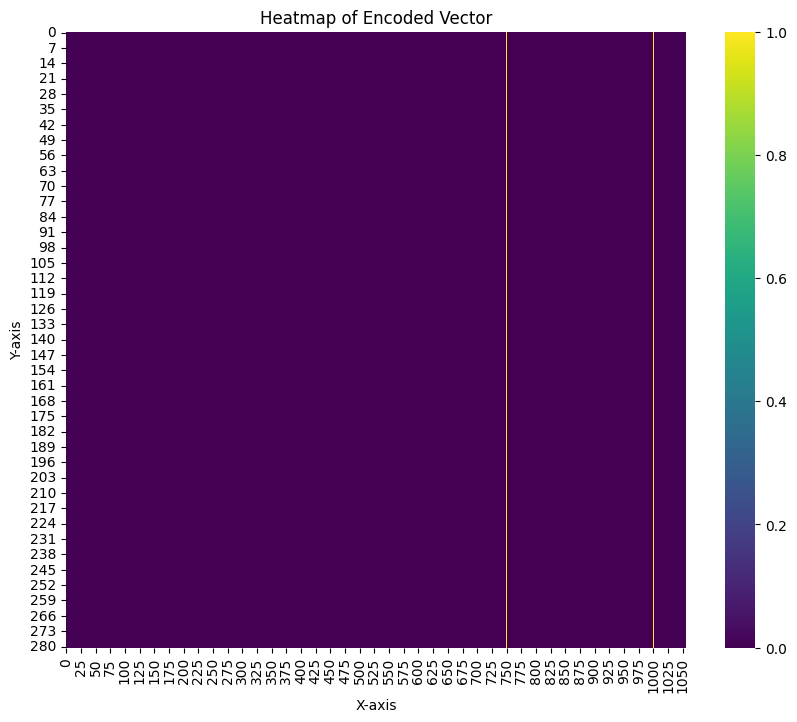

In [60]:
# prompt: plot heatmap

import matplotlib.pyplot as plt
import seaborn as sns


heatmap_data = encoded_vectors

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap="viridis")
plt.title("Heatmap of Encoded Vector")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()


In [61]:
import numpy as np

class FourHotEncoderFFT:
    def __init__(self, lat_range, lon_range, sog_max, n_bins, sigma_scale=0.001):
        self.sigma_scale = sigma_scale
        self.lat_bins = np.linspace(lat_range[0], lat_range[1], n_bins[0])
        self.lon_bins = np.linspace(lon_range[0], lon_range[1], n_bins[1])
        self.sog_bins = np.linspace(0, sog_max, n_bins[2])
        self.cog_bins = np.linspace(0, 360, n_bins[3])

    def gaussian_encoding(self, value, bins, sigma):
        encoding = np.exp(- (value - bins)**2 / (2 * sigma**2))
        return encoding / encoding.sum()

    def encode(self, x):
        lat_sigma = (self.lat_bins[1] - self.lat_bins[0]) * self.sigma_scale
        lon_sigma = (self.lon_bins[1] - self.lon_bins[0]) * self.sigma_scale
        sog_sigma = (self.sog_bins[1] - self.sog_bins[0]) * self.sigma_scale
        cog_sigma = (self.cog_bins[1] - self.cog_bins[0]) * self.sigma_scale

        lat_enc = self.gaussian_encoding(x[0], self.lat_bins, lat_sigma)
        lon_enc = self.gaussian_encoding(x[1], self.lon_bins, lon_sigma)
        sog_enc = self.gaussian_encoding(x[2], self.sog_bins, sog_sigma)
        cog_enc = self.gaussian_encoding(x[3], self.cog_bins, cog_sigma)

        # تحويل إلى المجال الترددي باستخدام FFT
        lat_enc_freq = np.fft.fft(lat_enc)
        lon_enc_freq = np.fft.fft(lon_enc)
        sog_enc_freq = np.fft.fft(sog_enc)
        cog_enc_freq = np.fft.fft(cog_enc)

        return np.concatenate([lat_enc_freq, lon_enc_freq, sog_enc_freq, cog_enc_freq])

    def decode(self, encoded):
        n_lat = len(self.lat_bins)
        n_lon = len(self.lon_bins)
        n_sog = len(self.sog_bins)
        n_cog = len(self.cog_bins)

        # إعادة التحويل من المجال الترددي باستخدام IFFT
        lat_enc_freq = encoded[:n_lat]
        lon_enc_freq = encoded[n_lat:n_lat+n_lon]
        sog_enc_freq = encoded[n_lat+n_lon:n_lat+n_lon+n_sog]
        cog_enc_freq = encoded[n_lat+n_lon+n_sog:]

        lat_enc = np.fft.ifft(lat_enc_freq).real
        lon_enc = np.fft.ifft(lon_enc_freq).real
        sog_enc = np.fft.ifft(sog_enc_freq).real
        cog_enc = np.fft.ifft(cog_enc_freq).real

        lat = np.sum(lat_enc * self.lat_bins)
        lon = np.sum(lon_enc * self.lon_bins)
        sog = np.sum(sog_enc * self.sog_bins)
        cog = np.sum(cog_enc * self.cog_bins)

        return np.round(np.array([lat, lon, sog, cog]), 4)

    def encode_batch(self, X):
        return np.array([self.encode(x) for x in X])

    def decode_batch(self, encoded_batch):
        return np.array([self.decode(enc) for enc in encoded_batch])





<ipython-input-59-cc719fce53ad>:12: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  encoding = np.exp(- (value - bins)**2 / (2 * sigma**2))


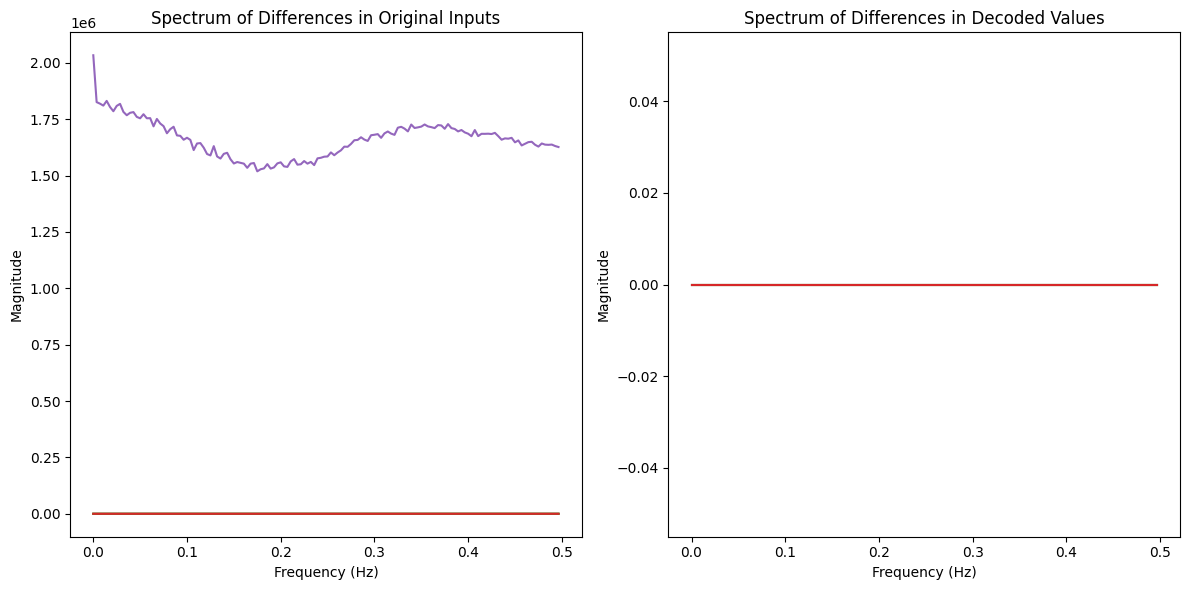

In [62]:
import numpy as np
import matplotlib.pyplot as plt


encoded_vectors = encoder.encode_batch(inputs)
decoded_values = encoder.decode_batch(encoded_vectors)

# تحويل المدخلات إلى مصفوفة numpy
input_matrix = np.array(inputs)
decoded_matrix = np.array(decoded_values)

# حساب الفرق بين كل صف والذي يليه
input_diff = np.diff(input_matrix, axis=0)
decoded_diff = np.diff(decoded_matrix, axis=0)

# تطبيق FFT لحساب الطيف
input_spectrum = np.fft.fft(input_diff, axis=0)
decoded_spectrum = np.fft.fft(decoded_diff, axis=0)

# حساب الترددات
frequencies = np.fft.fftfreq(input_spectrum.shape[0])

# رسم الطيف
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# رسم طيف المدخلات الأصلية
axes[0].plot(frequencies[:input_spectrum.shape[0]//2], np.abs(input_spectrum)[:input_spectrum.shape[0]//2])
axes[0].set_title("Spectrum of Differences in Original Inputs")
axes[0].set_xlabel("Frequency (Hz)")
axes[0].set_ylabel("Magnitude")

# رسم طيف القيم المفككة
axes[1].plot(frequencies[:decoded_spectrum.shape[0]//2], np.abs(decoded_spectrum)[:decoded_spectrum.shape[0]//2])
axes[1].set_title("Spectrum of Differences in Decoded Values")
axes[1].set_xlabel("Frequency (Hz)")
axes[1].set_ylabel("Magnitude")

plt.tight_layout()
plt.show()


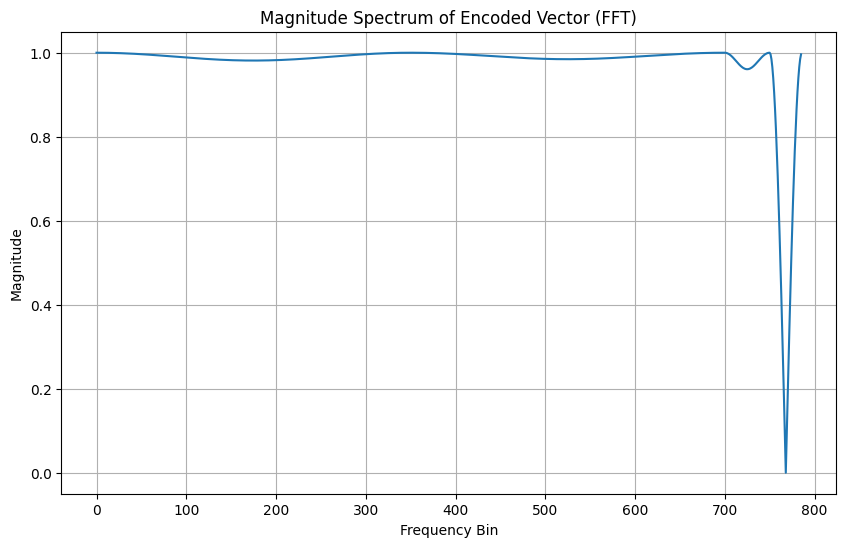

In [ ]:
# prompt: plot  encoded_vectors  ftt data

import matplotlib.pyplot as plt

# Assuming 'encoded_vectors' is your NumPy array of encoded vectors
# and you want to plot the magnitude of the FFT components

# Calculate the magnitude of the complex FFT coefficients
magnitudes = np.abs(encoded_vectors)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(magnitudes[0])  # Plot the magnitude spectrum for the first vector

plt.xlabel("Frequency Bin")
plt.ylabel("Magnitude")
plt.title("Magnitude Spectrum of Encoded Vector (FFT)")
plt.grid(True)
plt.show()


In [63]:
import torch
from torch.utils.data import Dataset
class AISDataset(Dataset):
    """Customized Pytorch dataset.
    """
    def __init__(self,
                 l_data,
                 max_seqlen=96,
                 dtype=torch.float32,
                 device=torch.device("cpu")):
        """
        Args
            l_data: list of dictionaries, each element is an AIS trajectory.
                l_data[idx]["mmsi"]: vessel's MMSI.
                l_data[idx]["traj"]: a matrix whose columns are
                    [LAT, LON, SOG, COG, TIMESTAMP]
                lat, lon, sog, and cod have been standardized, i.e. range = [0,1).
            max_seqlen: (optional) max sequence length. Default is
        """

        self.max_seqlen = max_seqlen
        self.device = device

        self.l_data = l_data

    def __len__(self):
        return len(self.l_data)

    def __getitem__(self, idx):
        """Gets items.

        Returns:
            seq: Tensor of (max_seqlen, [lat,lon,sog,cog]).
            mask: Tensor of (max_seqlen, 1). mask[i] = 0.0 if x[i] is a
            padding.
            seqlen: sequence length.
            mmsi: vessel's MMSI.
            time_start: timestamp of the starting time of the trajectory.
        """
        V = self.l_data[idx]
        m_v = V["traj"][:,:4] # lat, lon, sog, cog
#         m_v[m_v==1] = 0.9999
        m_v[m_v>0.9999] = 0.9999
        seqlen = min(len(m_v), self.max_seqlen)
        seq = np.zeros((self.max_seqlen,4))
        seq[:seqlen,:] = m_v[:seqlen,:]
        seq = torch.tensor(seq, dtype=torch.float32)

        mask = torch.zeros(self.max_seqlen)
        mask[:seqlen] = 1.

        seqlen = torch.tensor(seqlen, dtype=torch.int)
        mmsi =  torch.tensor(V["mmsi"], dtype=torch.int)
        time_start = torch.tensor(V["traj"][0,4], dtype=torch.int)

        return seq , mask, seqlen, mmsi, time_start

In [64]:

from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

train_dataset = AISDataset(train_data)
val_dataset = AISDataset(val_data)
test_dataset = AISDataset(test_data)




In [67]:

import pickle

with open('ct_dma_train.pkl', 'wb') as f:
  pickle.dump(train_data, f)


with open('ct_dma_valid.pkl', 'wb') as f:
  pickle.dump(val_data, f)

with open('ct_dma_test.pkl', 'wb') as f:
  pickle.dump(test_data, f)


In [ ]:
dataset=AISDataset(data)